In [1]:
# Disable warnings in Anaconda
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

In [3]:
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

In [4]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

In [5]:
data = pd.read_csv(DATA_PATH + "credit_scoring_sample.csv", sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [6]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of the target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

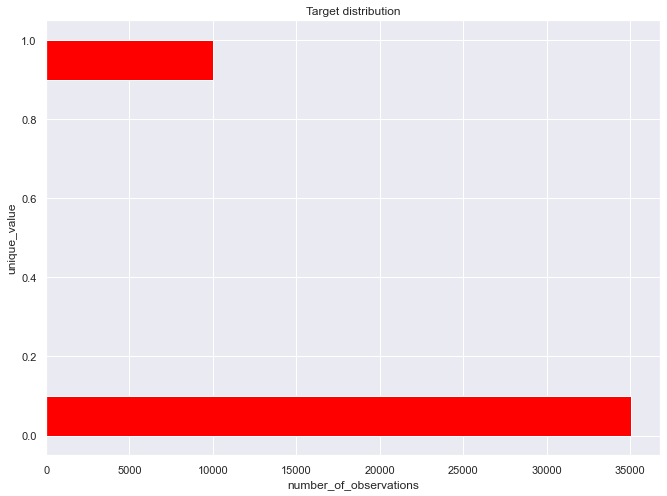

In [7]:
ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of the target:")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

In [8]:
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [9]:
table = fill_nan(data)

In [10]:
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

# Task 2

In [11]:
def get_bootstrap_samples(data, n_samples):
    """Generate bootstrap samples using the bootstrap method."""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def stat_intervals(stat, alpha):
    """Produce an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
    return boundaries

In [12]:
bad_costumers = table.loc[table["SeriousDlqin2yrs"] == 1, "age"].values
bad_costumers

array([49, 31, 37, ..., 31, 38, 45], dtype=int64)

In [13]:
bad_costumers_mean_score = [
    np.mean(sample) for sample in get_bootstrap_samples(bad_costumers, 1000)
]

In [14]:
print(
    "Age of the bad costumers: mean interval", stat_intervals(bad_costumers_mean_score, 0.1)
)

Age of the bad costumers: mean interval [45.70083283 46.15171554]


# Task 3

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [16]:
lr = LogisticRegression(random_state=5, class_weight="balanced")

In [17]:
parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

In [18]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [19]:
gcv = GridSearchCV(lr, parameters, n_jobs=-1, cv=skf, verbose=1, scoring="roc_auc")
gcv.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=5),
             n_jobs=-1, param_grid={'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)},
             scoring='roc_auc', verbose=1)

In [20]:
gcv.best_params_, gcv.best_score_

({'C': 0.001}, 0.8089120626797153)

# Task 4

In [21]:
parameters_C = [0.0001, 0.001, 0.01, 0.1, 1, 10]
scores_for_parameters = []
for parameter in parameters_C:
    #temp_gcv = GridSearchCV(lr, , n_jobs=-1, cv=skf, verbose=1, scoring="roc_auc")
    temp_lr = LogisticRegression(random_state=5, C=parameter, class_weight="balanced")
    temp_lr.fit(X, y)
    scores_for_parameters.append(temp_lr.score(X, y))
    
scores_for_parameters

[0.795641657235426,
 0.7919579255708674,
 0.7935778798570889,
 0.8217162638972105,
 0.7939773206399929,
 0.7939329383307814]

In [22]:
np.std(scores_for_parameters)

0.010452251069460022

GridSearchCV has attribute cv_results_(check sklearn documentation). It returns dictionary, so we get the result by this way.

In [23]:
gcv.cv_results_['std_test_score'][1]

0.008137559189742445

In [24]:
gcv.best_score_

0.8089120626797153

# Task 5

In [25]:
normalized_table=(table-table.mean())/table.std()
# normalized_df=(table-table.min())/(table.max()-table.min())

In [26]:
print(normalized_table)

       SeriousDlqin2yrs       age  NumberOfTime30-59DaysPastDueNotWorse  \
0             -0.534928  0.872881                             -0.121431   
1             -0.534928  0.463368                             -0.121431   
2             -0.534928 -0.696920                             -0.121431   
3             -0.534928 -0.560416                             -0.121431   
4              1.869368 -0.150902                             -0.121431   
...                 ...       ...                                   ...   
45058          1.869368 -1.379443                             -0.121431   
45059         -0.534928 -0.150902                             -0.121431   
45060          1.869368 -0.901677                             -0.121431   
45061         -0.534928 -0.287407                              0.040263   
45062          1.869368 -0.423911                              0.201957   

       DebtRatio  NumberOfTimes90DaysLate  \
0      -0.142575                -0.092451   
1       1

In [27]:
y_normalized = normalized_table["SeriousDlqin2yrs"]
X_normalized = normalized_table.drop(['SeriousDlqin2yrs'], axis=1)
normalized_lr = LogisticRegression(random_state=5, C=0.001, class_weight="balanced")
normalized_lr.fit(X, y)
importance=normalized_lr.coef_
importance=np.sort(importance)


In [28]:
importance

array([[-1.36555230e-02, -1.14783383e-05, -6.49390144e-06,
         1.91726108e-01,  2.16038225e-01,  3.90380766e-01,
         4.46832288e-01]])

In [29]:
for index,val in enumerate(importance):
    print("Feature : {} has score  : {} ".format(index,val))

Feature : 0 has score  : [-1.36555230e-02 -1.14783383e-05 -6.49390144e-06  1.91726108e-01
  2.16038225e-01  3.90380766e-01  4.46832288e-01] 


In [30]:
linreg_coeffs = pd.DataFrame(importance.transpose(), X_normalized.columns, columns=['Coefficients'])

linreg_coeffs.sort_values(by=['Coefficients'], ascending=False, axis=0)

,Coefficients
NumberOfDependents,0.446832
MonthlyIncome,0.390381
NumberOfTime60-89DaysPastDueNotWorse,0.216038
NumberOfTimes90DaysLate,0.191726
DebtRatio,-0.000006
NumberOfTime30-59DaysPastDueNotWorse,-0.000011
age,-0.013656


In [31]:
from sklearn.preprocessing import StandardScaler
lr = LogisticRegression(C=0.001, random_state=5, class_weight='balanced')
scal = StandardScaler()
lr.fit(scal.fit_transform(X), y)

coeffs = pd.DataFrame({'feat': independent_columns_names,
              'coef': lr.coef_.flatten().tolist()}).sort_values(by='coef', ascending=False)

coeffs

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.723427
3,NumberOfTimes90DaysLate,0.516788
4,NumberOfTime60-89DaysPastDueNotWorse,0.193558
6,NumberOfDependents,0.101443
2,DebtRatio,-0.024096
5,MonthlyIncome,-0.163146
0,age,-0.416702


# Task 6

In [32]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [33]:
scores = sorted(lr.coef_.flatten().tolist(), reverse=True)
print(softmax(scores))

[0.24129794 0.19625073 0.14204772 0.12954763 0.11426375 0.09943052
 0.0771617 ]


The DebtRatio's impact is 0.11

# Task 7

In [34]:
lr_without_scaling = LogisticRegression(C=0.001, random_state=5, class_weight='balanced')
lr_without_scaling.fit(X, y)

coeffs_without_scaling = pd.DataFrame({'feat': independent_columns_names,
              'coef': lr_without_scaling.coef_.flatten().tolist()}).sort_values(by='coef', ascending=False)

In [35]:
coeffs_without_scaling

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.446832
3,NumberOfTimes90DaysLate,0.390381
4,NumberOfTime60-89DaysPastDueNotWorse,0.216038
6,NumberOfDependents,0.191726
2,DebtRatio,-0.000006
5,MonthlyIncome,-0.000011
0,age,-0.013656


In [36]:
X_changed_age = X
X_changed_age.loc[X_changed_age["age"] > 0, "age"] += 20

In [37]:
X_changed_age

,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,84,0,0.249908,0,0,8158.0,0.0
1,78,0,3870.000000,0,0,5166.0,0.0
2,61,0,0.456127,0,0,6666.0,0.0
3,63,0,0.000190,0,0,10500.0,2.0
4,69,0,0.271820,0,0,400.0,0.0
...,...,...,...,...,...,...,...
45058,51,0,0.824725,0,0,3000.0,1.0
45059,69,0,6530.000000,0,0,0.0,5.0
45060,58,0,0.475841,0,0,3000.0,2.0
45061,67,1,0.485198,0,0,11720.0,5.0


In [38]:
lr_without_scaling.fit(X_changed_age, y)

LogisticRegression(C=0.001, class_weight='balanced', random_state=5)

In [39]:
lr_without_scaling.score(X_changed_age, y)

0.7987706100348401

answer is 0.83 below

In [40]:
np.exp(lr_without_scaling.coef_[0][0]*20)

0.8347177130493252

# Task 8

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
rf = RandomForestClassifier(
    n_estimators=100, n_jobs=-1, random_state=42, class_weight="balanced"
)

In [43]:
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

In [44]:
gcv_rf = GridSearchCV(rf, parameters, n_jobs=-1, cv=skf, verbose=1, scoring="roc_auc")
gcv_rf.fit(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15], 'max_features': [1, 2, 4],
                         'min_samples_leaf': [3, 5, 7, 9]},
             scoring='roc_auc', verbose=1)

In [45]:
gcv_rf.best_params_, gcv_rf.best_score_

({'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 9},
 0.8357785379863423)

In [46]:
print(gcv_rf.best_score_ - gcv.best_score_)

0.026866475306627002


In [47]:
print(gcv_rf.best_score_ - 0.7919)

0.043878537986342225


with C=0.001 we get 0.04, but it is not the best. The best gives us 0.025

# Task 9

In [48]:
rf = RandomForestClassifier(
    n_estimators=100, n_jobs=-1, random_state=42, class_weight="balanced",
    max_depth=10, max_features=2, min_samples_leaf=9
)
rf.fit(X, y)
rf.score(X, y)

0.8154583582983823

In [49]:
importances_rf = pd.DataFrame({'feat': independent_columns_names,
              'coef': rf.feature_importances_.flatten().tolist()}).sort_values(by='coef', ascending=False)

In [50]:
importances_rf

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.300290
3,NumberOfTimes90DaysLate,0.278749
4,NumberOfTime60-89DaysPastDueNotWorse,0.156534
0,age,0.115860
2,DebtRatio,0.076082
5,MonthlyIncome,0.057994
6,NumberOfDependents,0.014491


NumberOfDependents has the weakest impact - 0.01

# Task 10

Logistic regression is better interpretated than random forest

# Task 11

In [105]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

parameters_cv = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100],
}

In [106]:
#log_regression = LogisticRegression(random_state=42, class_weight='balanced')

In [107]:
#bagging_clf = BaggingClassifier(log_regression, n_estimators=100, random_state=42)

In [108]:
randomized_cv = RandomizedSearchCV(BaggingClassifier(LogisticRegression(class_weight="balanced"), n_estimators=100, random_state=42, n_jobs=-1), 
                                   parameters_cv, n_iter=20, n_jobs=-1, random_state=1, cv=5, scoring="roc_auc", verbose=True)

In [109]:
#print(cross_val_score(randomized_cv, X, y, scoring="roc_auc", cv=3))
randomized_cv.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced'),
                                               n_estimators=100, n_jobs=-1,
                                               random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'base_estimator__C': [0.0001, 0.001,
                                                              0.01, 1, 10,
                                                              100],
                                        'max_features': [2, 3, 4],
                                        'max_samples': [0.5, 0.7, 0.9]},
                   random_state=1, scoring='roc_auc', verbose=True)

In [110]:
randomized_cv.best_params_, randomized_cv.best_score_

({'max_samples': 0.7, 'max_features': 2, 'base_estimator__C': 100},
 0.8092965904943765)

In [111]:
randomized_cv.best_estimator_

BaggingClassifier(base_estimator=LogisticRegression(C=100,
                                                    class_weight='balanced'),
                  max_features=2, max_samples=0.7, n_estimators=100, n_jobs=-1,
                  random_state=42)

# Task 12

less correlation between single models